In this notebook, we explore the abstract column and do clustering as well as topic modelling.

**References for tutorials followed** - 
[1] https://towardsdatascience.com/exploring-the-un-general-debates-with-dynamic-topic-models-72dc0e307696

[2] https://radimrehurek.com/gensim/models/ldaseqmodel.html

[3] https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [0]:
import sys
colab = 'google.colab' in sys.modules

In [0]:
import pandas as pd
path = "/content/EGC_dataset.csv"
df = pd.read_csv(path)
df.head()

,series,booktitle,year,title,abstract,authors,pdf1page,pdfarticle
0,Revue des Nouvelles Technologies de l'Information,EGC,2018,#Idéo2017 : une plateforme citoyenne dédiée à ...,Cette plateforme a pour objectif de permettre ...,"Claudia Marinica, Julien Longhi, Nader Hassine...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002425
1,Revue des Nouvelles Technologies de l'Information,EGC,2018,A two level co-clustering algorithm for very l...,La classification croisée (co-clustering) est ...,"Marius Barctus, Marc Boullé, Fabrice Clérot",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002372
2,Revue des Nouvelles Technologies de l'Information,EGC,2018,ALGeoSPF: Un modèle de factorisation basé sur ...,La recommandation de points d'intérêts est dev...,"Jean-Benoît Griesner, Talel Abdesssalem, Huber...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002380
3,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse des sentiments à partir des commentair...,L'analyse des sentiments est un processus pend...,"Abdeljalil Elouardighi, Mohcine Maghfour, Hafd...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002397
4,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse en rôles sémantiques pour le résumé au...,Cet article présente une approche visant à ext...,"Elyase Lassouli, Yasmine Mesbahi, Camille Prad...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002384


**We shall start with diong a K-means clustering just to see if some patterns are visiable easily.**

In [0]:
# Create a copy of the data [to leave original data unchanged.]
df1 = df.copy()

# Since we found in ExploratoryAnalysis.ipynb that there were missing abstracts,
# we shall drop those missing entries
# Check for empty data
import numpy as np

cols_to_check = ['title','abstract','authors']
for i in cols_to_check:
  index_missing = np.where(df.isnull()[i])
  print('# samples with no', i, ':', len(index_missing[0]))

get_missing_index = np.where(df.isnull()['abstract'])[0]
df1 = df1.drop(get_missing_index)

# samples with no title : 0
# samples with no abstract : 173
# samples with no authors : 0


In [0]:
print('Sample size:', df1.shape)

Sample size: (1096, 8)


**K-Means [High level]**

In [0]:
# Create TFIDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 5,max_df = 0.95,max_features = 8000)
tfidf.fit(df1.abstract)
text = tfidf.transform(df1.abstract)

In [0]:
# 5 clusters
from sklearn.cluster import KMeans
n_clusters = 5
km = KMeans(n_clusters=n_clusters)
km.fit(text)
clusters = km.labels_.tolist()

In [0]:
# Add clusters to df2 (copy of df1)
df2 = df1.copy()
df2['cluster'] = clusters
print(df2['cluster'].value_counts())

4    430
3    334
1    176
0    103
2     53
Name: cluster, dtype: int64


In [0]:
# Fit an LDA and get top topics per cluster
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

from sklearn.decomposition import LatentDirichletAllocation

def get_topics(df, n_topics = 10, n_words= 20):
  tfidf = TfidfVectorizer(max_features = 1000)
  
  list_text = df.to_list()
  result = tfidf.fit_transform(list_text)
  lda = LatentDirichletAllocation(n_components= n_topics, learning_method='online',
                                learning_offset=50.)
  lda.fit(result)
  tf_feature_names = tfidf.get_feature_names()
  print_top_words(lda, tf_feature_names, n_words)
  return result

In [0]:
i = 0
while i < n_clusters:
  get_topics(df2[df2.cluster==i].abstract, n_topics = 2, n_words= 3)
  i+=1

Topic #0: the of we
Topic #1: the of and

Topic #0: de et des
Topic #1: de des la

Topic #0: de les motifs
Topic #1: de des motifs

Topic #0: social de km
Topic #1: de des les

Topic #0: de la des
Topic #1: de les une



**The first cluster has English words. We shall check if there are some documents that are in English.**

In [0]:
!pip install langdetect
from langdetect import detect
language = []
for i in range(df1.shape[0]):
  language.append(detect(df1.abstract.iloc[i]))
languageset = set(language)
print(languageset)

     |████████████████████████████████| 1.0MB 2.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=3bb641e3198dc6c74e6ba3ef67811351d5fe443595354209e74bc22a73b3081e
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
{'fr', 'en'}


**We have documents in English and French both.**

In [0]:
# Get indices of documents in either language
idx_en = []
for i in range(df1.shape[0]):
  if language[i] == 'en':
    idx_en.append(i)

idx_fr = []
for i in range(df1.shape[0]):
  if language[i] == 'fr':
    idx_fr.append(i)

In [0]:
print("Number of English papers", len(idx_en))
print("Their indices", idx_en)

Number of English papers 105
Their indices [72, 87, 115, 118, 122, 123, 124, 126, 130, 133, 139, 148, 149, 154, 155, 159, 160, 162, 165, 177, 180, 182, 183, 185, 193, 198, 200, 206, 207, 208, 209, 210, 224, 225, 230, 235, 237, 238, 240, 241, 242, 251, 252, 263, 266, 277, 278, 313, 321, 328, 331, 338, 339, 350, 356, 368, 386, 398, 403, 410, 413, 427, 428, 442, 444, 448, 452, 456, 463, 487, 489, 494, 495, 512, 525, 531, 550, 571, 572, 582, 595, 615, 625, 628, 632, 633, 639, 643, 666, 675, 682, 692, 707, 715, 726, 744, 766, 832, 843, 892, 906, 921, 929, 1056, 1061]


In [0]:
# Seperate these
df_en = df1.iloc[idx_en]
df_fr = df1.iloc[idx_fr]
print(df_en.iloc[0]) # 

series        Revue des Nouvelles Technologies de l'Information
booktitle                                                   EGC
year                                                       2017
title         Deep Dive on Smart Cities by Scaling Reasoning...
abstract      Modern cities are facing tremendous amount of ...
authors                                            Freddy Lécué
pdf1page      http://editions-rnti.fr/render_pdf.php?p1&p=10...
pdfarticle     http://editions-rnti.fr/render_pdf.php?p=1002264
Name: 89, dtype: object


**Save these and also create a seperate column to have the index in the original dataframe.**

In [0]:
# Save english ones to csv
df_en = df_en.reset_index()
df_en.to_csv('en_EGC_dataset.csv', index=False)

# Save french ones to csv
df_fr = df_fr.reset_index()
df_fr.to_csv('fr_EGC_dataset.csv', index=False)

In [0]:
df_en.head()

,index,series,booktitle,year,title,abstract,authors,pdf1page,pdfarticle
0,89,Revue des Nouvelles Technologies de l'Information,EGC,2017,Deep Dive on Smart Cities by Scaling Reasoning...,Modern cities are facing tremendous amount of ...,Freddy Lécué,http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002264
1,109,Revue des Nouvelles Technologies de l'Information,EGC,2017,Machine Learning for the Semantic Web: filling...,"In the Semantic Web view, ontologies play a ke...",Claudia d’Amato,http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002262
2,142,Revue des Nouvelles Technologies de l'Information,EGC,2017,"“Engage moi”: From retrieval effectiveness, us...",The effective prediction of a click remains a ...,Mounia Lalmas,http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002261
3,145,Revue des Nouvelles Technologies de l'Information,EGC,2016,Analyse d'activité et exposition de la vie pri...,Anonymous use of Social network do not prevent...,"Younes Abid, Abdessamad Imine, Amedeo Napoli, ...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002223
4,149,Revue des Nouvelles Technologies de l'Information,EGC,2016,Apprentissage du signal prix de l'électricité....,Predicting the price of the electricity commod...,"Louis-Victor Pasquier, Antoine Cornuéjols, Suz...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002222


In [0]:
df_fr.head()

,index,series,booktitle,year,title,abstract,authors,pdf1page,pdfarticle
0,0,Revue des Nouvelles Technologies de l'Information,EGC,2018,#Idéo2017 : une plateforme citoyenne dédiée à ...,Cette plateforme a pour objectif de permettre ...,"Claudia Marinica, Julien Longhi, Nader Hassine...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002425
1,1,Revue des Nouvelles Technologies de l'Information,EGC,2018,A two level co-clustering algorithm for very l...,La classification croisée (co-clustering) est ...,"Marius Barctus, Marc Boullé, Fabrice Clérot",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002372
2,2,Revue des Nouvelles Technologies de l'Information,EGC,2018,ALGeoSPF: Un modèle de factorisation basé sur ...,La recommandation de points d'intérêts est dev...,"Jean-Benoît Griesner, Talel Abdesssalem, Huber...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002380
3,3,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse des sentiments à partir des commentair...,L'analyse des sentiments est un processus pend...,"Abdeljalil Elouardighi, Mohcine Maghfour, Hafd...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002397
4,4,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse en rôles sémantiques pour le résumé au...,Cet article présente une approche visant à ext...,"Elyase Lassouli, Yasmine Mesbahi, Camille Prad...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002384


**The column index shows the index of the row in original dataframe before we seperated these documents.**

**K-Means done the right way.**

**French Papers** 

**Step. 0**. See the top words to get an idea about the choice of stopwords.

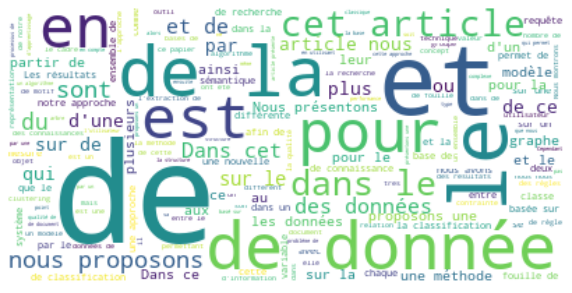

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=100, max_words=800, background_color="white").generate(' '.join(df_fr['abstract']))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
# French stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import FrenchStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stopword = set(stopwords.words('french'))
porter = PorterStemmer()
snowball_stemmer = FrenchStemmer()
print("french stop words: ", stopword)
print("Number of french stop words: ", len(stopword))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
french stop words:  {'fussent', 'avions', 'étées', 'aurions', 'es', 'ayante', 'serais', 'les', 'il', 'l', 'as', 'eue', 'ayant', 'aurez', 'aurais', 'notre', 'fus', 'avons', 'eusse', 'ta', 'eussent', 'étés', 'avait', 'y', 'soit', 'fussions', 'j', 'se', 'aurai', 'auront', 'ils', 'n', 'sur', 'ayez', 'serait', 'sommes', 'fûmes', 'en', 'mes', 'pas', 'étaient', 'eus', 'd', 'aurait', 'fût', 'soient', 'aura', 'qui', 'mon', 'étant', 'seriez', 'ses', 'étions', 'été', 'tu', 'ou', 'étants', 'ces', 'fusse', 'eussiez', 'furent', 'fut', 'aient', 'seront', 'tes', 'eues', 'elle', 'de', 'pour', 'ton', 'étais', 'vos', 'seraient', 'la', 'un', 'te', 'est', 'ma', 'étée', 'serez', 'avec', 'aie', 'sont', 'une', 'serai', 'ce', 'eusses', 'on', 'me', 'étiez', 'même', 'fusses', 'que', 'du', 'soyez', '

In [0]:
print("partir" in stopword)
print("article" in stopword)

False
False


**We do not know French but the number of stopwords seem pretty low (157). Due to this, we shall download a larger list of stopwords. [Available at as part of [stopwords-iso](https://github.com/stopwords-iso/stopwords-fr/blob/master/stopwords-fr.txt)]**

In [0]:
!npm install stopwords-fr

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ stopwords-fr@0.2.0
added 1 package from 1 contributor in 1.028s


In [0]:
stopword_file = './node_modules/stopwords-fr/stopwords-fr.json'
import json
with open(stopword_file) as f:
  stopword = json.load(f)

**We shall also add some data mining related stopwords. [Again, since we don't know French, this may contain errors.]**

In [0]:
stopword=stopword+['donner', 'variable', 'variables', 'data', 'sciences', 'méthode', 'méthodes', 'technique', 'techniques', 'donnes', 'partir', 'article', 'articles', 
                 'algorithme', 'algorithmes', 'approche', 'approches','système', 'papier', 'contribution', 'recherche', 'utiliser', 'données', 'nouvelle', 'proposer',
                 'rechercher', 'méthode', 'utilisér']

In [0]:
print("Updated french stop words: ", stopword)
print("Number of updated french stop words: ", len(stopword))

Updated french stop words:  ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'aient', 'aies', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 'aucun', 'aucune', 'aucuns', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayez', 'ayons', 'b', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'bon', 'boum', 'bravo', 'brrr', 'c', 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 'celui', 'celui-ci', 'celui-là', 'celà', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 'certes', 'ces', '

**Wordcloud after removing stopwords**

**Step.1**. Clean abstract and remove stopwords.



In [0]:
!python -m spacy download fr
!pip install spacy
!pip install spacy_lefff
import spacy
from spacy_lefff import LefffLemmatizer, POSTagger

     |████████████████████████████████| 13.1MB 4.1MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.1.0-cp36-none-any.whl size=13156209 sha256=1abc6d28e2916ca2dba157d2a9896ec4e93f1e8dc2409c0b866ef4e3403c63e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-c1y1_b44/wheels/ab/82/2a/61dd0ff02e22f10eef65a5aa35453a0eb745c84b4c874b612f
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')
     |████████████████████████████████| 3.0MB 32kB/s 
  Created wheel for spacy-lefff: filename=spacy_lefff-0.3.6-cp36-none-any.whl size=2929362 sha256=11e945960143d26c849fa68e37789ff356ad294ec68f2fb47252a8616d73d542
  Stored in directory: /root/.cache/pip/wheels/c0/a9/04/33568eb2af0feda8a290f7d940cc120419a8a41752e9b85db4
Succes

In [0]:
nlp = spacy.load('fr')
pos = POSTagger()
french_lemmatizer = LefffLemmatizer(after_melt=True, default=True)
nlp.add_pipe(pos, name='pos', after='parser')
nlp.add_pipe(french_lemmatizer, name='lefff', after='pos')

2020-01-23 21:21:50,446 - spacy_lefff.downloader - INFO - downloading data for tagger...
2020-01-23 21:21:50,450 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): www.dropbox.com:443
2020-01-23 21:21:50,753 - urllib3.connectionpool - DEBUG - https://www.dropbox.com:443 "GET /s/xjn863wq4599vur/model.tar.gz?dl=1 HTTP/1.1" 301 0
2020-01-23 21:21:51,101 - urllib3.connectionpool - DEBUG - https://www.dropbox.com:443 "GET /s/dl/xjn863wq4599vur/model.tar.gz HTTP/1.1" 302 0
2020-01-23 21:21:51,106 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): uc2c7c68d9602ebc3e85565e49c4.dl.dropboxusercontent.com:443
2020-01-23 21:21:51,859 - urllib3.connectionpool - DEBUG - https://uc2c7c68d9602ebc3e85565e49c4.dl.dropboxusercontent.com:443 "GET /cd/0/get/AwvbobEQYnBewLO8jLRbmeiEZ_waqajNXyjwMDrbWWXdIjGlq8rl9CPhV7dSUHtQDY3yNkKlHsBCcixjIJsq_RR2EDgnETvIN8oTZ3B9efL5eQ/file?dl=1 HTTP/1.1" 200 88861140


 95%|█████████▌| 84.6M/88.9M [00:03<00:00, 27.3MB/s]

2020-01-23 21:21:56,678 - spacy_lefff.downloader - INFO - download complete


100%|██████████| 88.9M/88.9M [00:04<00:00, 18.4MB/s]

2020-01-23 21:21:56,684 - spacy_lefff.melt_tagger - INFO -   TAGGER: Loading lexicon...


2020-01-23 21:21:57,105 - spacy_lefff.melt_tagger - INFO -   TAGGER: Loading tags...
2020-01-23 21:21:57,129 - spacy_lefff.melt_tagger - INFO -   TAGGER: Loading model from /usr/local/lib/python3.6/dist-packages/spacy_lefff/data/tagger/models/fr...
2020-01-23 21:21:57,550 - spacy_lefff.melt_tagger - INFO -   TAGGER: Loading model from /usr/local/lib/python3.6/dist-packages/spacy_lefff/data/tagger/models/fr: done
2020-01-23 21:21:57,551 - spacy_lefff.lefff - INFO - New LefffLemmatizer instantiated.
2020-01-23 21:21:57,552 - spacy_lefff.lefff - INFO - Token lefff_lemma already registered
2020-01-23 21:21:57,553 - spacy_lefff.lefff - INFO - Reading lefff data...
2020-01-23 21:21:57,985 - spacy_lefff.lefff - INFO - Successfully loaded lefff lemmatizer


In [0]:
def tokenize(text):
    if not isinstance(text, str):
      # print('continue')
      return
    #words = word_tokenize(text) #split words
    #words = [w.lower() for w in words if w.isalpha()] 
    #words =[w for w in words if  not w in stopword]
    
    #stemmed = [snowball_stemmer.stem(w) for w in words]
    #lemmatized = [nlp(unicode(w, "utf-8")).french_lemmatizer for w in stemmed]
    words = nlp(text)
    lemmatized = [w._.lefff_lemma for w in words]
    
    return lemmatized
    # return text

def filtered_token(text):

    words = text.split() #split words
    words = [w.lower() for w in words if w.isalpha()] 
    words = [w for w in words if  not w in stopword]

    return words

In [0]:
# Make lowercase and remove stopwords
tmp = df_fr.abstract.map(filtered_token)
df_fr['abstract_cleaned'] = tmp
for i in range(df_fr.shape[0]):
  tmp = ' '.join(map(str, df_fr['abstract_cleaned'][i]))
  df_fr['abstract_cleaned'][i] = tmp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
# Lemmatize and again check for stopwords
tmp = df_fr.abstract_cleaned.map(tokenize)
df_fr['abstract_cleaned'] = tmp
for i in range(df_fr.shape[0]):
  tmp = ' '.join(map(str, df_fr['abstract_cleaned'][i]))
  df_fr['abstract_cleaned'][i] = tmp

tmp = df_fr.abstract_cleaned.map(filtered_token)
df_fr['abstract_cleaned'] = tmp

2020-01-23 21:22:38,985 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,007 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,036 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,073 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,114 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,148 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,180 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,218 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,248 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,271 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,302 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tagging...
2020-01-23 21:22:39,333 - spacy_lefff.melt_tagger - INFO -   TAGGER: POS Tag

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
for i in range(df_fr.shape[0]):
  tmp = ' '.join(map(str, df_fr['abstract_cleaned'][i]))
  df_fr['abstract_cleaned'][i] = tmp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df_fr.head()

,index,series,booktitle,year,title,abstract,authors,pdf1page,pdfarticle,abstract_cleaned
0,0,Revue des Nouvelles Technologies de l'Information,EGC,2018,#Idéo2017 : une plateforme citoyenne dédiée à ...,Cette plateforme a pour objectif de permettre ...,"Claudia Marinica, Julien Longhi, Nader Hassine...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002425,plateforme objectif permettre citoyen tweets p...
1,1,Revue des Nouvelles Technologies de l'Information,EGC,2018,A two level co-clustering algorithm for very l...,La classification croisée (co-clustering) est ...,"Marius Barctus, Marc Boullé, Fabrice Clérot",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002372,classification croisé existant ligne colonne t...
2,2,Revue des Nouvelles Technologies de l'Information,EGC,2018,ALGeoSPF: Un modèle de factorisation basé sur ...,La recommandation de points d'intérêts est dev...,"Jean-Benoît Griesner, Talel Abdesssalem, Huber...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002380,recommandation point devenue caractéristiquees...
3,3,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse des sentiments à partir des commentair...,L'analyse des sentiments est un processus pend...,"Abdeljalil Elouardighi, Mohcine Maghfour, Hafd...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002397,sentiment processus négatif texte donné intére...
4,4,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse en rôles sémantiques pour le résumé au...,Cet article présente une approche visant à ext...,"Elyase Lassouli, Yasmine Mesbahi, Camille Prad...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002384,présenter visant extraire information exprimée...


In [0]:
def get_mat(df, n_topics = 10, n_words= 20):
  tfidf = TfidfVectorizer(max_features = 1000)
  result = tfidf.fit_transform(df)
  
  return result

In [0]:
mat = get_mat(df_fr.abstract_cleaned)
print(mat.shape)

(991, 1000)


**Step.2.** Optimal Number of clusters - Elbow Method

In [0]:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(mat)
    Sum_of_squared_distances.append(km.inertia_)

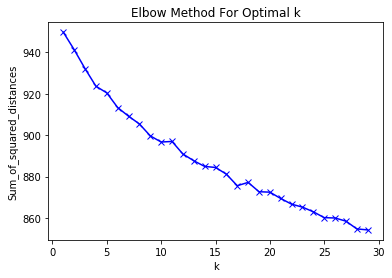

In [0]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**Try with Minibatch to see if SSE converges beyond 30 clusters.**

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters
Fit 52 clusters
Fit 54 clusters
Fit 56 clusters
Fit 58 clusters
Fit 60 clusters
Fit 62 clusters
Fit 64 clusters
Fit 66 clusters
Fit 68 clusters
Fit 70 clusters
Fit 72 clusters
Fit 74 clusters
Fit 76 clusters
Fit 78 clusters
Fit 80 clusters
Fit 82 clusters
Fit 84 clusters
Fit 86 clusters
Fit 88 clusters
Fit 90 clusters


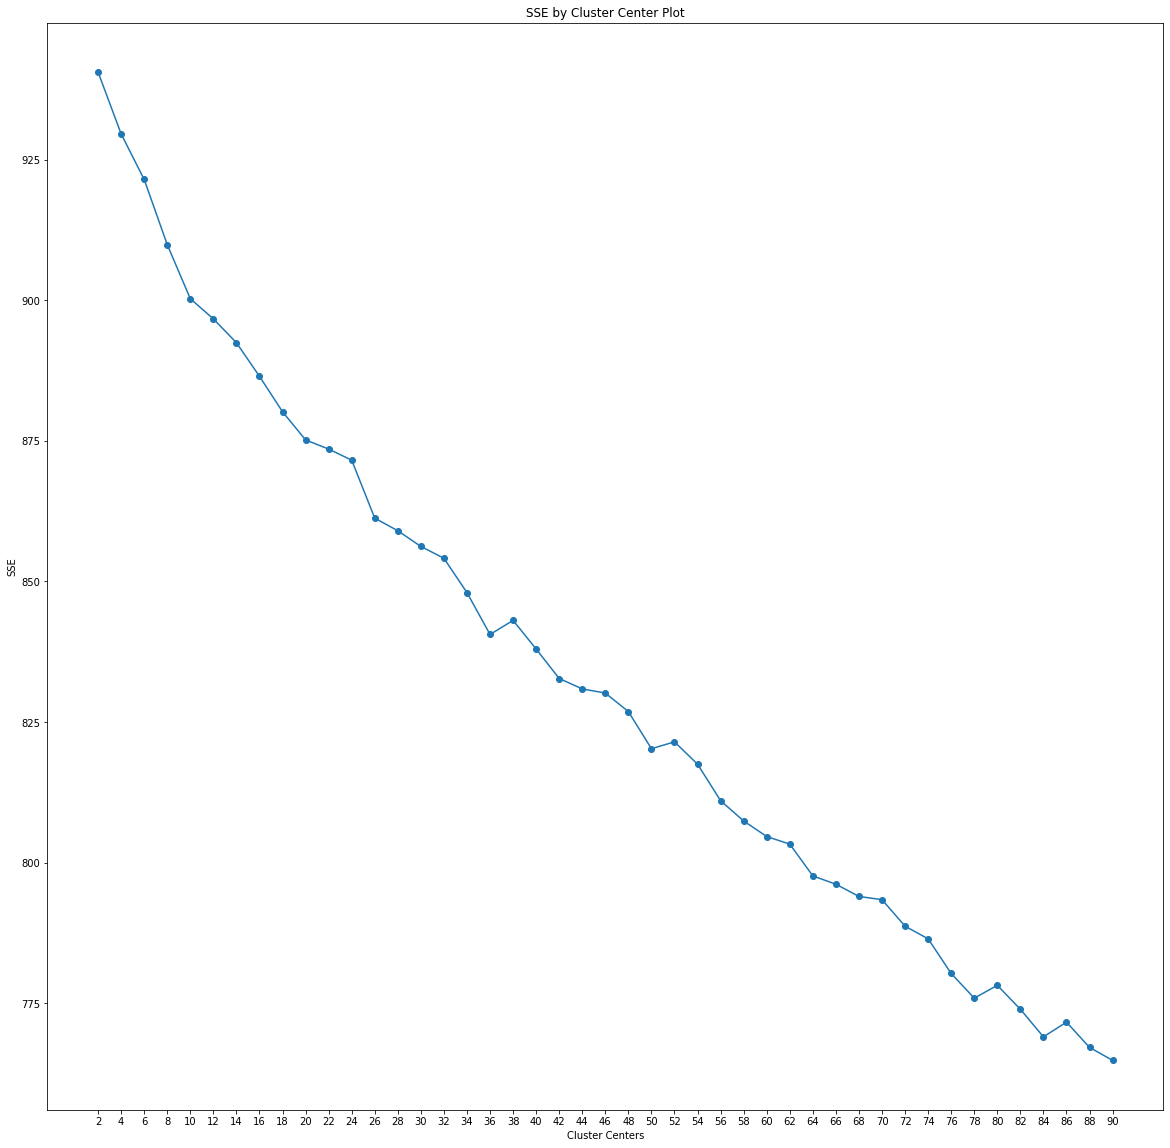

In [0]:
from sklearn.cluster import MiniBatchKMeans
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    sse = []
    
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=2).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
    
    f, ax = plt.subplots(1, 1, figsize=(20,20))
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(mat, 90)

**Clearly, SSE doe not converge till 90 clusters. So, K-Means may not be very appropriate to use.**

In [0]:
# Choose 30 clusters
km = KMeans(n_clusters=30)
km = km.fit(mat)
clusters = km.labels_.tolist()

In [0]:
# Add clusters to df2 (copy of df1)
df_fr['kmean_cluster'] = clusters
print(df_fr['kmean_cluster'].value_counts())

10    67
11    53
3     51
4     49
28    49
24    47
0     45
18    45
16    44
6     42
8     40
14    36
1     34
9     34
27    31
13    31
2     30
22    28
12    26
23    24
7     24
15    23
19    21
17    20
26    19
21    19
20    18
5     15
25    13
29    13
Name: kmean_cluster, dtype: int64


**Visualize clusters**

In [0]:
clusters = np.array(clusters, dtype='int')

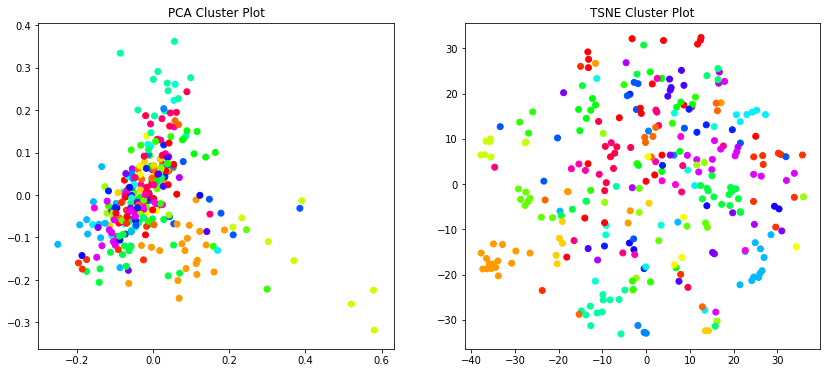

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=900, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(mat, clusters)

**K Means not appropriate to use clearly. Clusters are not very well defined.**

**We shall now do topic modelling and evaluate the topic model results. We shall also try to cluster on those topics later.**

**Step 4. Build corpus or bag of words**

In [0]:
!pip install pyLDAvis
!pip install gensim
from gensim import corpora, models
import gensim
import pyLDAvis.gensim

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 28kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=4db5dc7caca434ba7f789215e24295347d2f8cbf31fb17223602ce17f8cee7f5
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=123c49bf0509204d5fb77314e566c5ce13e59fd01da83acb600df14b775c783f
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
2020-01-23 21:26:15,017 - summarizer.preprocessing.cleaner - INFO - 'pattern' package not found; tag filters are not available for English
2020-01-23 21:26:15,103 - root - INFO - Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2020-01-23 21:26:15,128 - root - INFO - Generating grammar tables from /usr/lib/pytho

In [0]:
df_fr.head()

,index,series,booktitle,year,title,abstract,authors,pdf1page,pdfarticle,abstract_cleaned
0,0,Revue des Nouvelles Technologies de l'Information,EGC,2018,#Idéo2017 : une plateforme citoyenne dédiée à ...,Cette plateforme a pour objectif de permettre ...,"Claudia Marinica, Julien Longhi, Nader Hassine...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002425,plateforme objectif permettre citoyen tweets p...
1,1,Revue des Nouvelles Technologies de l'Information,EGC,2018,A two level co-clustering algorithm for very l...,La classification croisée (co-clustering) est ...,"Marius Barctus, Marc Boullé, Fabrice Clérot",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002372,classification croisé existant ligne colonne t...
2,2,Revue des Nouvelles Technologies de l'Information,EGC,2018,ALGeoSPF: Un modèle de factorisation basé sur ...,La recommandation de points d'intérêts est dev...,"Jean-Benoît Griesner, Talel Abdesssalem, Huber...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002380,recommandation point devenue caractéristiquees...
3,3,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse des sentiments à partir des commentair...,L'analyse des sentiments est un processus pend...,"Abdeljalil Elouardighi, Mohcine Maghfour, Hafd...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002397,sentiment processus négatif texte donné intére...
4,4,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse en rôles sémantiques pour le résumé au...,Cet article présente une approche visant à ext...,"Elyase Lassouli, Yasmine Mesbahi, Camille Prad...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002384,présenter visant extraire information exprimée...


**Tokenize and create a dictionary. Also include bi and trigrams**

In [0]:
tmp = df_fr.abstract_cleaned.map(filtered_token)
df_fr['abstract_cleaned'] = tmp

In [0]:
from nltk.tokenize import RegexpTokenizer
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    return docs

In [0]:
docs = docs_preprocessor(df_fr.abstract_cleaned)
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2020-01-23 21:29:41,131 - gensim.models.phrases - INFO - collecting all words and their counts
2020-01-23 21:29:41,132 - gensim.models.phrases - INFO - PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-01-23 21:29:41,193 - gensim.models.phrases - INFO - collected 41246 word types from a corpus of 38712 words (unigram + bigrams) and 991 sentences
2020-01-23 21:29:41,193 - gensim.models.phrases - INFO - using 41246 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
2020-01-23 21:29:41,195 - gensim.models.phrases - INFO - collecting all words and their counts
2020-01-23 21:29:41,197 - gensim.models.phrases - INFO - PROGRESS: at sentence #0, processed 0 words and 0 word types


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


2020-01-23 21:29:41,395 - gensim.models.phrases - INFO - collected 41330 word types from a corpus of 38388 words (unigram + bigrams) and 991 sentences
2020-01-23 21:29:41,397 - gensim.models.phrases - INFO - using 41330 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [0]:
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]

2020-01-23 21:29:49,746 - gensim.corpora.dictionary - INFO - adding document #0 to Dictionary(0 unique tokens: [])
2020-01-23 21:29:49,794 - gensim.corpora.dictionary - INFO - built Dictionary(7642 unique tokens: ['analyser', 'citoyen', 'comparaison', 'fournir', 'lexique']...) from 991 documents (total 40167 corpus positions)


In [0]:
for idx, word in dictionary.iteritems():
  print(idx, word)

0 analyser
1 citoyen
2 comparaison
3 fournir
4 lexique
5 message
6 objectif
7 permettre
8 plateforme
9 politique
10 principal
11 présidentiel
12 quasitemps
13 réel
14 spécifique
15 tweets
16 actuel
17 application
18 atteindre
19 calcul
20 classification
21 classification_croisé
22 colonne
23 compte
24 critère
25 croisé
26 efficacement
27 existant
28 expérience
29 former
30 gagner
31 grand
32 ligne
33 ligne_colonne
34 modl
35 montrer
36 optimiser
37 passer
38 pouvant
39 produisant
40 proposée
41 présentons
42 solution
43 succès
44 tabler
45 taille
46 temps
47 temps_calcul
48 tenu
49 traiter
50 utilisées
51 vraisemblance
52 allant
53 baséesur
54 caractéristiqueessentielle
55 cependantles
56 clusteringspatial
57 comparatif
58 comportement
59 conduitune
60 densité
61 devenue
62 difficile
63 espace
64 explorons
65 expérimental
66 factorisation
67 faible
68 massif
69 matrice
70 mobilitédes
71 modèle
72 monder
73 notreapproche
74 performance
75 point
76 poisson
77 problème
78 précision
79 qua

In [0]:
first_bow_doc = corpus[0]
display(", ".join(df_fr.abstract_cleaned[0]))
# bow representation
for i in range(len(first_bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(first_bow_doc[i][0],
                                               dictionary[first_bow_doc[i][0]],
                                               first_bow_doc[i][1]))

'plateforme, objectif, permettre, citoyen, tweets, politique, spécifique, cas, présidentiel, analyser, quasitemps, réel, message, fournir, principal, lexique, politique, comparaison'

Word 0 ("analyser") appears 1 time.
Word 1 ("citoyen") appears 1 time.
Word 2 ("comparaison") appears 1 time.
Word 3 ("fournir") appears 1 time.
Word 4 ("lexique") appears 1 time.
Word 5 ("message") appears 1 time.
Word 6 ("objectif") appears 1 time.
Word 7 ("permettre") appears 1 time.
Word 8 ("plateforme") appears 1 time.
Word 9 ("politique") appears 2 time.
Word 10 ("principal") appears 1 time.
Word 11 ("présidentiel") appears 1 time.
Word 12 ("quasitemps") appears 1 time.
Word 13 ("réel") appears 1 time.
Word 14 ("spécifique") appears 1 time.
Word 15 ("tweets") appears 1 time.


In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=20)
import pprint
pprint.pprint(ldamodel.top_topics(corpus,topn=5))

2020-01-23 21:33:06,066 - gensim.models.ldamodel - INFO - using symmetric alpha at 0.06666666666666667
2020-01-23 21:33:06,068 - gensim.models.ldamodel - INFO - using symmetric eta at 0.06666666666666667
2020-01-23 21:33:06,071 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2020-01-23 21:33:06,094 - gensim.models.ldamodel - INFO - running online (multi-pass) LDA training, 15 topics, 20 passes over the supplied corpus of 991 documents, updating model once every 991 documents, evaluating perplexity every 991 documents, iterating 50x with a convergence threshold of 0.001000
2020-01-23 21:33:06,107 - gensim.models.ldamodel - DEBUG - bound: at document #0
2020-01-23 21:33:07,008 - gensim.models.ldamodel - INFO - -13.712 per-word bound, 13420.2 perplexity estimate based on a held-out corpus of 991 documents with 40167 words
2020-01-23 21:33:07,009 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #991/991
2020-01-23 21:33:07,010 - gensim.models.ldamodel

2020-01-23 21:34:16,041 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
2020-01-23 21:34:16,043 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-01-23 21:34:16,046 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2020-01-23 21:34:16,048 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-01-23 21:34:16,049 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
2020-01-23 21:34:16,050 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
2020-01-23 21:34:

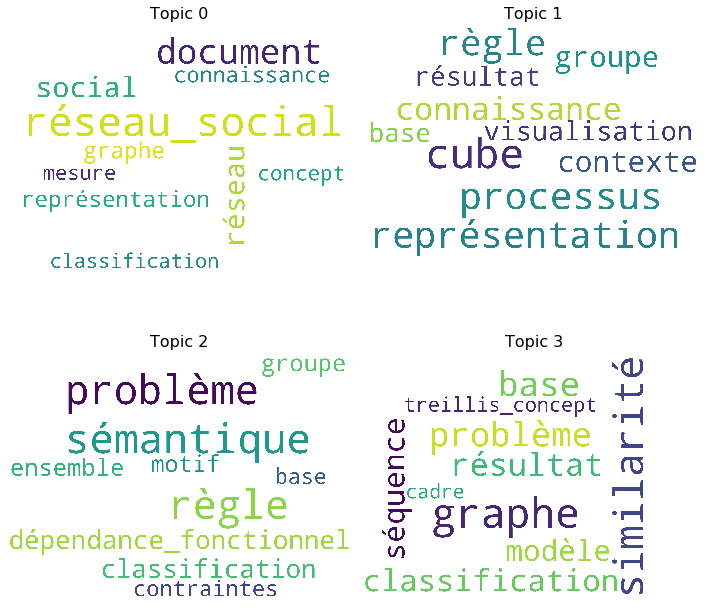

In [0]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cloud = WordCloud(stopwords=stopword,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=1000)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [0]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score
coherence_model_lda_npmi = CoherenceModel(model=ldamodel, texts=docs, dictionary=dictionary, coherence='c_npmi')
coherence_model_lda_cv = CoherenceModel(model=ldamodel, texts=docs, dictionary=dictionary, coherence='c_v')
c_npmi_score = coherence_model_lda_npmi.get_coherence()
c_v_score = coherence_model_lda_cv.get_coherence()

print('\n c_npmi: ', c_npmi_score)
print('\n c_v: ', c_v_score)

2020-01-23 21:34:50,190 - gensim.models.coherencemodel - DEBUG - Setting topics to those of the model: LdaModel(num_terms=7642, num_topics=15, decay=0.5, chunksize=2000)
2020-01-23 21:34:50,201 - gensim.models.coherencemodel - DEBUG - Setting topics to those of the model: LdaModel(num_terms=7642, num_topics=15, decay=0.5, chunksize=2000)
2020-01-23 21:34:50,210 - gensim.topic_coherence.probability_estimation - INFO - using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2020-01-23 21:34:50,238 - gensim.topic_coherence.text_analysis - INFO - WordOccurrenceAccumulator accumulated stats from 1000 documents
2020-01-23 21:34:50,256 - gensim.topic_coherence.text_analysis - INFO - WordOccurrenceAccumulator accumulated stats from 2000 documents
2020-01-23 21:34:50,276 - gensim.topic_coherence.text_analysis - INFO - WordOccurrenceAccumulator accumulated stats from 3000 documents
2020-01-23 21:34:50,294 - gensim.topic_coherence.text_analysis - INFO - WordOccurrenceAccumu

In [0]:
len(corpus)

991

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=100, step=6)

2020-01-23 21:35:18,826 - gensim.models.ldamodel - INFO - using symmetric alpha at 0.5
2020-01-23 21:35:18,829 - gensim.models.ldamodel - INFO - using symmetric eta at 0.5
2020-01-23 21:35:18,834 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2020-01-23 21:35:18,845 - gensim.models.ldamodel - INFO - running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 991 documents, updating model once every 991 documents, evaluating perplexity every 991 documents, iterating 50x with a convergence threshold of 0.001000
2020-01-23 21:35:18,846 - gensim.models.ldamodel - WARNING - too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-01-23 21:35:18,856 - gensim.models.ldamodel - DEBUG - bound: at document #0
2020-01-23 21:35:19,717 - gensim.models.ldamodel - INFO - -9.466 per-word bound, 707.1 perplexity estimate based on a held-out corpus of 991 documents with 40167 words

2020-01-23 21:36:44,385 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2020-01-23 21:36:44,386 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-01-23 21:36:44,387 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2020-01-23 21:36:44,389 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-01-23 21:36:44,390 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
2020-01-23 21:36:44,392 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
2020-01-23 21:36:

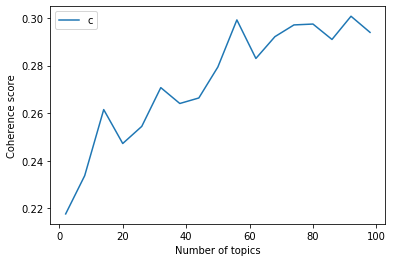

In [0]:
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**We can see that for optimal number of topics lie beyond 100, which is not very meaningful as we shall have many repeated words. Therefoe, we choose number of topics to be 25, where the graph has a local maxima. We can study their evolution of time as well as see differences among topics.**

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=25, id2word = dictionary, passes=20)
import pprint
pprint.pprint(ldamodel.top_topics(corpus,topn=5))

2020-01-23 21:49:43,449 - gensim.models.ldamodel - INFO - using symmetric alpha at 0.04
2020-01-23 21:49:43,451 - gensim.models.ldamodel - INFO - using symmetric eta at 0.04
2020-01-23 21:49:43,455 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2020-01-23 21:49:43,483 - gensim.models.ldamodel - INFO - running online (multi-pass) LDA training, 25 topics, 20 passes over the supplied corpus of 991 documents, updating model once every 991 documents, evaluating perplexity every 991 documents, iterating 50x with a convergence threshold of 0.001000
2020-01-23 21:49:43,501 - gensim.models.ldamodel - DEBUG - bound: at document #0
2020-01-23 21:49:44,497 - gensim.models.ldamodel - INFO - -18.419 per-word bound, 350525.3 perplexity estimate based on a held-out corpus of 991 documents with 40167 words
2020-01-23 21:49:44,498 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #991/991
2020-01-23 21:49:44,499 - gensim.models.ldamodel - DEBUG - performing inferen

In [0]:
# Compute Coherence Score
coherence_model_lda_cv = CoherenceModel(model=ldamodel, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_score = coherence_model_lda_cv.get_coherence()
print('\n c_v: ', c_v_score)

2020-01-23 21:50:19,631 - gensim.models.coherencemodel - DEBUG - Setting topics to those of the model: LdaModel(num_terms=7642, num_topics=25, decay=0.5, chunksize=2000)
2020-01-23 21:50:19,639 - gensim.topic_coherence.probability_estimation - INFO - using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2020-01-23 21:50:19,882 - gensim.topic_coherence.text_analysis - INFO - WordOccurrenceAccumulator accumulated stats from 1000 documents

 c_v:  0.28678588091586127


In [0]:
# Save model 
ldamodel.save('lda.gensim')

2020-01-23 21:50:26,350 - gensim.utils - INFO - saving LdaState object under lda.gensim.state, separately None
2020-01-23 21:50:26,352 - smart_open.smart_open_lib - DEBUG - {'transport_params': {}, 'ignore_ext': False, 'opener': None, 'closefd': True, 'newline': None, 'errors': None, 'encoding': None, 'buffering': -1, 'mode': 'wb', 'uri': 'lda.gensim.state'}
2020-01-23 21:50:26,368 - gensim.utils - INFO - saved lda.gensim.state
2020-01-23 21:50:26,369 - smart_open.smart_open_lib - DEBUG - {'transport_params': {}, 'ignore_ext': False, 'opener': None, 'closefd': True, 'newline': None, 'errors': None, 'encoding': None, 'buffering': -1, 'mode': 'wb', 'uri': 'lda.gensim.id2word'}
2020-01-23 21:50:26,375 - gensim.utils - INFO - saving LdaModel object under lda.gensim, separately ['expElogbeta', 'sstats']
2020-01-23 21:50:26,376 - gensim.utils - INFO - storing np array 'expElogbeta' to lda.gensim.expElogbeta.npy
2020-01-23 21:50:26,379 - gensim.utils - INFO - not storing attribute dispatcher


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Visualize**

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
vis

2020-01-23 21:50:38,900 - gensim.models.ldamodel - DEBUG - performing inference on a chunk of 991 documents
2020-01-23 21:50:39,107 - gensim.models.ldamodel - DEBUG - 991/991 documents converged within 50 iterations
2020-01-23 21:50:39,133 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.044858  0.042634       1        1  6.229249
5      0.078050 -0.029558       2        1  6.146230
17     0.051825 -0.003818       3        1  5.977102
23     0.073669 -0.015636       4        1  5.756251
7      0.033498  0.008092       5        1  4.898029
14     0.018086  0.031782       6        1  4.826892
22     0.052193  0.008246       7        1  4.736995
24     0.037336 -0.009843       8        1  4.605350
21     0.026249  0.086394       9        1  4.347116
8      0.013346  0.014487      10        1  4.344555
11    -0.001566  0.016221      11        1  4.296309
20    -0.039959  0.164595      12        1  4.188334
16     0.039732  0.048086      13        1  4.099856
0      0.051011 -0.011031      14        1  4.094621
3      0.016182 -0.012178      15        1  3.863026
2      0.049155 -0.105185      16        1  3.772319
12     0.025606 -0.087795      17        1  3.635878
10    -0.046308  0.004952      18        1  3.411900
13    -0.011335 -0.005524      19        1  3.328110
9     -0.055860 -0.056677      20        1  2.729827
18    -0.044936 -0.035670      21        1  2.387317
1     -0.097284 -0.036476      22        1  2.324592
4     -0.063076  0.061571      23        1  2.235504
15    -0.096204 -0.086188      24        1  1.888187
19    -0.154269  0.008518      25        1  1.876455, topic_info=     Category        Freq  ...  loglift  logprob
501   Default  182.000000  ...  30.0000  30.0000
83    Default  100.000000  ...  29.0000  29.0000
1649  Default   85.000000  ...  28.0000  28.0000
1772  Default   86.000000  ...  27.0000  27.0000
118   Default  114.000000  ...  26.0000  26.0000
...       ...         ...  ...      ...      ...
7     Topic25    2.235539  ...   0.0209  -5.8205
187   Topic25    2.188087  ...  -0.1361  -5.8420
86    Topic25    2.187947  ...   0.8228  -5.8421
40    Topic25    2.187841  ...   0.9281  -5.8421
130   Topic25    2.187635  ...   0.5981  -5.8422

[2361 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
1785      7  0.238123             abordée
1785     11  0.476246             abordée
1785     15  0.238123             abordée
2856      1  0.598220             abordés
2856     23  0.299110             abordés
...     ...       ...                 ...
3560      5  0.590224           évaluéeen
3454      6  0.598021          évènements
3454     19  0.299011          évènements
3914     11  0.598056  évènementssurvenus
2757     14  0.599549     êtreinsuffisant

[6858 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 18, 24, 8, 15, 23, 25, 22, 9, 12, 21, 17, 1, 4, 3, 13, 11, 14, 10, 19, 2, 5, 16, 20])

In [0]:
pyLDAvis.save_html(vis, 'ldaVis.html')

In [0]:
pyLDAvis.save_html(vis, './drive/My Drive/mallet/ldaVis.html')

**Step 4**. Evolution of topics over time [Word Cloud for different years) [From overleaf]

In [0]:
year_list = np.unique(df_fr.year)
yearly_articles = []
for i in year_list:
  yearly_articles.append(df_fr[df_fr.year == i].shape[0])
print('No. of articles per year:', yearly_articles)

No. of articles per year: [58, 74, 76, 90, 92, 56, 78, 66, 50, 51, 78, 48, 61, 57, 56]


In [0]:
dictionary[0]

'analysait'

In [0]:
# Dynamic LDA
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ldaseq = gensim.models.ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=yearly_articles, num_topics=25, em_max_iter=3)

2020-01-23 21:58:12,213 - gensim.models.ldamodel - INFO - using symmetric eta at 0.04
2020-01-23 21:58:12,215 - gensim.models.ldamodel - INFO - using serial LDA version on this node
2020-01-23 21:58:12,245 - gensim.models.ldamodel - INFO - running online (multi-pass) LDA training, 25 topics, 10 passes over the supplied corpus of 991 documents, updating model once every 991 documents, evaluating perplexity every 991 documents, iterating 50x with a convergence threshold of 0.001000
2020-01-23 21:58:12,260 - gensim.models.ldamodel - DEBUG - bound: at document #0
2020-01-23 21:58:13,241 - gensim.models.ldamodel - INFO - -18.387 per-word bound, 342803.0 perplexity estimate based on a held-out corpus of 991 documents with 40167 words
2020-01-23 21:58:13,242 - gensim.models.ldamodel - INFO - PROGRESS: pass 0, at document #991/991
2020-01-23 21:58:13,243 - gensim.models.ldamodel - DEBUG - performing inference on a chunk of 991 documents
2020-01-23 21:58:14,041 - gensim.models.ldamodel - DEBUG 

/usr/local/lib/python3.6/dist-packages/gensim/models/ldaseqmodel.py:290: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


2020-01-23 22:07:20,287 - gensim.models.ldaseqmodel - INFO - M Step
2020-01-23 22:07:20,288 - gensim.models.ldaseqmodel - INFO - Fitting topic number 0
2020-01-23 22:07:21,314 - gensim.models.ldaseqmodel - INFO - Computing bound, all times
2020-01-23 22:07:22,265 - gensim.models.ldaseqmodel - INFO - initial sslm bound is 212998.746245
2020-01-23 22:07:24,317 - gensim.models.ldaseqmodel - INFO - Computing bound, all times
2020-01-23 22:07:25,248 - gensim.models.ldaseqmodel - INFO - iteration 1 iteration lda seq bound is 212996.218540 convergence is 0.000012
2020-01-23 22:07:26,268 - gensim.models.ldaseqmodel - INFO - Computing bound, all times
2020-01-23 22:07:27,216 - gensim.models.ldaseqmodel - INFO - iteration 2 iteration lda seq bound is 212992.492508 convergence is 0.000017
2020-01-23 22:07:27,555 - gensim.models.ldaseqmodel - INFO - Fitting topic number 1
2020-01-23 22:07:28,582 - gensim.models.ldaseqmodel - INFO - Computing bound, all times
2020-01-23 22:07:29,525 - gensim.models

In [0]:
# Save model
ldaseq.save('ldaseq.gensim')

2020-01-23 22:28:16,506 - gensim.utils - INFO - saving LdaSeqModel object under ldaseq.gensim, separately None
2020-01-23 22:28:16,509 - smart_open.smart_open_lib - DEBUG - {'transport_params': {}, 'ignore_ext': False, 'opener': None, 'closefd': True, 'newline': None, 'errors': None, 'encoding': None, 'buffering': -1, 'mode': 'wb', 'uri': 'ldaseq.gensim'}


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


2020-01-23 22:28:17,832 - gensim.utils - INFO - saved ldaseq.gensim


In [0]:
topics = ldaseq.dtm_coherence(time=14) #2018
cm_wrapper = CoherenceModel(topics=topics, texts=docs, dictionary=dictionary, coherence='c_v')
print ("C_v topic coherence")
print ("Coherence for 2018 is ", cm_wrapper.get_coherence())

C_v topic coherence
2020-01-23 22:28:18,255 - gensim.topic_coherence.probability_estimation - INFO - using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2020-01-23 22:28:18,349 - gensim.topic_coherence.text_analysis - INFO - WordOccurrenceAccumulator accumulated stats from 1000 documents
Coherence for 2018 is  0.3003084693997476


**Topic Evolution - Topic 0**

In [0]:
slices = list(range(0,len(year_list)))

In [0]:
def topic_evolution(topic_number,n_terms: int):
  """
  Returns top topics along with probabilities for the specified topic.
  Input:
  topic_number = Between 0 and 24 [total 25 topics]
  n_terms = How many top words to return for the topic

  Output:
  dataframe containing yearly top terms and their probabilities
  """
  out = ldaseq.print_topic_times(topic_number, top_terms=n_terms)
  columns = [None]*2*len(year_list)
  for i in range(len(year_list)):
    columns[i*2] = str(year_list[i])
    columns[i+1] = 'prob_'+str(year_list[i])
  data = pd.DataFrame(index=list(range(n_terms)), columns=year_list)
  j=1
  for i in slices:
    yearly_top_terms = np.array((out[i]))[:,0]
    data[str(year_list[i])] = yearly_top_terms
    yearly_probs = np.array((out[i]))[:,1]
    data['prob_'+str(year_list[i])] = yearly_probs
    j += 2

  return data.dropna(axis=1)

In [0]:
topic_evolution(21, 30)

,2004,prob_2004,2005,prob_2005,2006,prob_2006,2007,prob_2007,2008,prob_2008,2009,prob_2009,2010,prob_2010,2011,prob_2011,2012,prob_2012,2013,prob_2013,2014,prob_2014,2015,prob_2015,2016,prob_2016,2017,prob_2017,2018,prob_2018
0,réseau_social,0.04351333813697635,réseau_social,0.043787938657986816,réseau_social,0.043480745331111535,réseau_social,0.043012079182866904,réseau_social,0.041400869728875966,réseau_social,0.03885420698857573,réseau_social,0.036149677447251095,réseau_social,0.033972176101748464,réseau_social,0.03268506238814664,réseau_social,0.03193420655958039,réseau_social,0.030965861588409287,réseau_social,0.03001148680201274,réseau_social,0.029229852218267793,réseau_social,0.02885081479689388,réseau_social,0.028619350331351958
1,réseau,0.019177194976395365,réseau,0.019297098499359587,réseau,0.019319505072940092,réseau,0.019274075621059143,réseau,0.01904476941623804,réseau,0.018399957968492302,réseau,0.017798923088402543,réseau,0.01720220072385043,réseau,0.01685194072718925,réseau,0.016633378020130915,réseau,0.016405377329264063,réseau,0.016147880049137843,réseau,0.01593097412273551,réseau,0.015823065715312584,réseau,0.01575674188849582
2,social,0.017632471078113093,social,0.017731329980358188,social,0.017795618973628035,social,0.017779804122345096,social,0.01758043566071777,social,0.017034823590457698,social,0.01650752882586489,social,0.015968202663641646,modèle,0.01589770122795961,modèle,0.01564478270655746,modèle,0.01545227350691014,modèle,0.015369052092064149,modèle,0.015323808761616287,modèle,0.015219684613625226,modèle,0.015157326163916155
3,modèle,0.01604877761719592,modèle,0.016180949163813803,modèle,0.016292965894910763,modèle,0.016407677664242313,modèle,0.016271676985127253,modèle,0.016191360330649086,modèle,0.016127200572064737,modèle,0.015943420734827258,social,0.015630197726353913,social,0.015405469646728908,social,0.0152247483194928,social,0.015005465303840509,social,0.01481922604030117,social,0.014726230485282361,social,0.014671454397841975
4,relation,0.011551560311075052,relation,0.01156894582301278,relation,0.011657468351814188,relation,0.011826536946603553,relation,0.012144868622312349,relation,0.012497387527081391,relation,0.012781475874139058,relation,0.012985368859478236,relation,0.012852257328473896,relation,0.01273635153034016,relation,0.01267440771500156,relation,0.012623677318505515,relation,0.012595626875861578,relation,0.012632638916907727,relation,0.012693767755558092
5,détecter,0.006533818435417503,détecter,0.006515623174249211,détecter,0.006457124171543896,détecter,0.006391954528875152,automatique,0.006435748816535888,concept,0.0065546460848258485,concept,0.006650474868955307,automatique,0.006794650599365899,automatique,0.00692695079512427,automatique,0.006936762571853936,automatique,0.007003261647190891,automatique,0.007057665169754331,classification,0.007196705732312264,classification,0.007297304455435879,classification,0.007379345203676237
6,groupe,0.006272927543398028,groupe,0.006310110456015699,automatique,0.0062984973611185085,automatique,0.0063536317510973815,concept,0.006372246620370747,automatique,0.006533454838608375,automatique,0.006640927231074323,concept,0.00672325216246795,concept,0.006824076859695352,concept,0.006906799755004423,concept,0.006906938770224055,classification,0.007033571841036976,automatique,0.007064225849783187,automatique,0.007078009361935712,automatique,0.007097456905462354
7,automatique,0.006251446077754471,automatique,0.006265044325343253,groupe,0.006243949959801945,concept,0.006245645121580306,détecter,0.00627337611185235,classification,0.006307463531801339,classification,0.006398120398185471,classification,0.006529501354074218,classification,0.006632258815622455,classification,0.0067504471759219295,classification,0.006879452909652979,concept,0.006875377591512291,concept,0.006847558307259614,concept,0.006831574272580425,concept,0.006820618649341409
8,classification,0.006128916027347122,classification,0.006155910227971426,concept,0.006178297045749994,class

**Do the same as above for every topic and save**

In [0]:
for i in range(25):
  df = topic_evolution(i, 30)
  csvname = 'topic'+str(i)+'Evolution.csv'
  df.to_csv(csvname, sep=',')

In [0]:
np.where(topic20)

**Visualize topic evolution**

In [0]:
topic10 = topic_evolution(10, 30)

In [0]:
topic10 = topic_evolution(10, 30)
topic10_arbredecision = []
for i in range(len(year_list)):
  col = str(year_list[i])
  idx = np.where(topic10[col]=='arbre_décision')[0]
  tmp = np.array(topic10['prob_'+str(year_list[i])], dtype='float32')
  topic10_arbredecision.append(tmp[idx])

topic10_semantique = []
for i in range(len(year_list)):
  col = str(year_list[i])
  idx = np.where(topic20[col]=='sémantique')[0]
  tmp = np.array(topic20['prob_'+str(year_list[i])], dtype='float32')
  topic10_semantique.append(tmp[idx])

topic1 = topic_evolution(1, 30)
topic1_ensemble = []
for i in range(len(year_list)):
  col = str(year_list[i])
  idx = np.where(topic1[col]=='ensemble')[0]
  tmp = np.array(topic1['prob_'+str(year_list[i])], dtype='float32')
  topic1_ensemble.append(tmp[idx])

topic1_classification = []
for i in range(len(year_list)):
  col = str(year_list[i])
  idx = np.where(topic1[col]=='classification')[0]
  tmp = np.array(topic1['prob_'+str(year_list[i])], dtype='float32')
  topic1_classification.append(tmp[idx])

topic1_carte_cognitif = []
for i in range(len(year_list)):
  col = str(year_list[i])
  idx = np.where(topic1[col]=='carte_cognitif')[0]
  tmp = np.array(topic1['prob_'+str(year_list[i])], dtype='float32')
  topic1_carte_cognitif.append(tmp[idx])

topic5 = topic_evolution(5, 30)
topic5_visualisation = []
for i in range(len(year_list)):
  col = str(year_list[i])
  idx = np.where(topic5[col]=='visualisation')[0]
  tmp = np.array(topic5['prob_'+str(year_list[i])], dtype='float32')
  topic5_visualisation.append(tmp[idx])

topic21 = topic_evolution(21, 30)
topic21_reseausocial = []
for i in range(len(year_list)):
  col = str(year_list[i])
  idx = np.where(topic21[col]=='réseau_social')[0]
  tmp = np.array(topic21['prob_'+str(year_list[i])], dtype='float32')
  topic21_reseausocial.append(tmp[idx])

Text(0.5, 1.0, 'Term-Evolution')

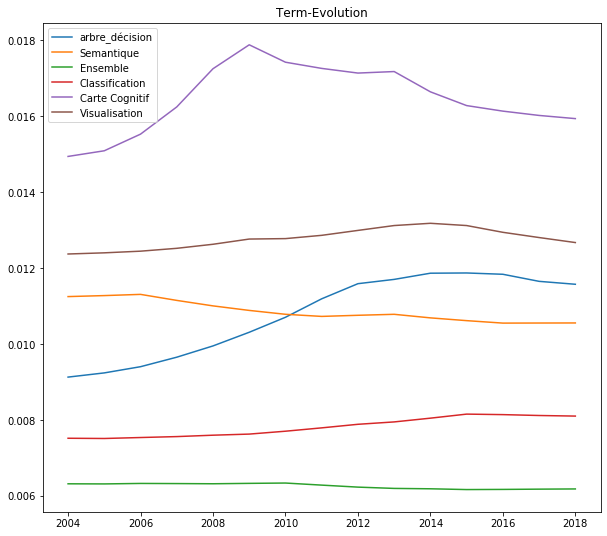

In [0]:
plt.figure(figsize=(10,9))
plt.plot(year_list, topic10_arbredecision)
plt.plot(year_list, topic10_semantique)
plt.plot(year_list, topic1_ensemble)
plt.plot(year_list, topic1_classification)
plt.plot(year_list, topic1_carte_cognitif)
plt.plot(year_list, topic5_visualisation)
plt.legend(['arbre_décision', 'Semantique', 'Ensemble', 'Classification', 'Carte Cognitif', 
            'Visualisation'], loc='upper left')
plt.title('Term-Evolution')

Text(0.5, 1.0, 'Term-Evolution (Term - réseau_social in Topic 21)')

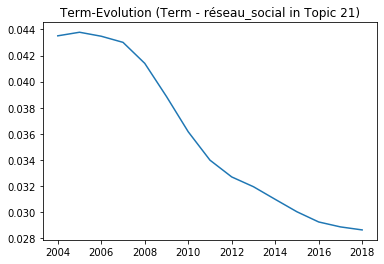

In [0]:
plt.plot(year_list, topic21_reseausocial)
plt.title('Term-Evolution (Term - réseau_social in Topic 21)')

**Same can be done on English documents. Since documents are only 105, we shall not do topic modelling on it. But will do clustering.**